In [1]:
# Heavily borrows from https://github.com/Priesemann-Group/covid19_inference

import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

import pandas as pd
import time
import datetime

import pickle
import datetime

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

#import sys
#sys.path.append('..')
#import ModelInfo

rki_df = pd.read_csv("data/RKI_COVID19_200527.csv", sep=",") 

def rdate(s):
    r = None
    if "T" in s:
        r = datetime.datetime.strptime(s.split("T")[0],"%Y-%m-%d")
    if "-" in s:
        r = datetime.datetime.strptime(s.split(" ")[0],"%Y-%m-%d")
    else:
        if s[:4] == "2020":
            r = datetime.datetime.strptime(s.split(" ")[0],"%Y/%m/%d")
        else:
            r = datetime.datetime.strptime(s.split(" ")[0],"%m/%d/%Y")
    return r.date()

cols = [x for x in ["Meldedatum","Refdatum"] if x in rki_df.columns]
for col in cols:
    if col in rki_df:
        rki_df[col] = rki_df[col].apply(rdate)
        
rki_df = rki_df.filter(items=["Meldedatum","Refdatum","NeuerFall","AnzahlFall","IstErkrankungsbeginn"])

def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner


In [2]:
# Testing as taken from the RKI situation-report
testing = {} # as of April 8th 
testing["KW10 (up inc.)"] = [datetime.date(2020,2,10),87863,2763,48]
testing["KW11"] = [datetime.date(2020,3,9),127457,7582,114]
testing["KW12"] = [datetime.date(2020,3,16),348619,23820,152]
testing["KW13"] = [datetime.date(2020,3,23),360964,31347,149]
testing["KW14"] = [datetime.date(2020,3,30),392984,34389,143]

testing = {}
testing["KW10 (up inc.)"] = [datetime.date(2020,2,10),124716,3982,90]
testing["KW11"] = [datetime.date(2020,3,9),127457,7582,114]
testing["KW12"] = [datetime.date(2020,3,16),348619,23820,152]
testing["KW13"] = [datetime.date(2020,3,23),361515,31414,151]
testing["KW14"] = [datetime.date(2020,3,30),408348,36885,154]
testing["KW15"] = [datetime.date(2020,4,6),379233,30728,163]
testing["KW16"] = [datetime.date(2020,4,13),330027,21993,167]
testing["KW17"] = [datetime.date(2020,4,20),361999,18052,177]
testing["KW18"] = [datetime.date(2020,4,27),325259,12585,174]
testing["KW19"] = [datetime.date(2020,5,4),402044,10746,181]
testing["KW20"] = [datetime.date(2020,5,11),425842,7060,176]

if True:
# Testing as taken from the RKI situation-report - updated 2020-05-27
# Backlog is taken from bulletin 15/20 p.3
    testing = {}
    testing["KW10 (up inc.)"] = [datetime.date(2020,2,10),124716,3982,90]
    testing["KW11"] = [datetime.date(2020,3,9),127457,7582,114]
    testing["KW12"] = [datetime.date(2020,3,16),348619,23820,152,26548]
    testing["KW13"] = [datetime.date(2020,3,23),361515,31414,151,31998]
    testing["KW14"] = [datetime.date(2020,3,30),408348,36885,154]
    testing["KW15"] = [datetime.date(2020,4,6),380197,30791,164]
    testing["KW16"] = [datetime.date(2020,4,13),331902,22082,168]
    testing["KW17"] = [datetime.date(2020,4,20),363890,18083,178]
    testing["KW18"] = [datetime.date(2020,4,27),326788,12608,175]
    testing["KW19"] = [datetime.date(2020,5,4),403875,10755,182]
    testing["KW20"] = [datetime.date(2020,5,11),430882,7227,181]
    testing["KW21"] = [datetime.date(2020,5,18),344782,5116,172] 

if False:
# Testing as taken from the RKI situation-report - updated 2020-06-03
    testing = {}
    testing["KW10 (up inc.)"] = [datetime.date(2020,2,10),124716,3982,90]
    testing["KW11"] = [datetime.date(2020,3,9),127457,7582,114]
    testing["KW12"] = [datetime.date(2020,3,16),348619,23820,152,26548]
    testing["KW13"] = [datetime.date(2020,3,23),361515,31414,151,31998]
    testing["KW14"] = [datetime.date(2020,3,30),408348,36885,154]
    testing["KW15"] = [datetime.date(2020,4,6),380197,30791,164]
    testing["KW16"] = [datetime.date(2020,4,13),331902,22082,168]
    testing["KW17"] = [datetime.date(2020,4,20),363890,18083,178]
    testing["KW18"] = [datetime.date(2020,4,27),326788,12608,175]
    testing["KW19"] = [datetime.date(2020,5,4),403875,10755,182]
    testing["KW20"] = [datetime.date(2020,5,11),432666,7233,182]
    testing["KW21"] = [datetime.date(2020,5,18),346470,5121,174] 
    testing["KW22"] = [datetime.date(2020,5,25),392437,3107,169]

    
# Data
tpd = pd.DataFrame.from_dict(testing, orient='index',columns=["startdate","tests","positive","labs","backlog"])
tpd["fraction"]  = tpd["positive"]/tpd["tests"]

print(tpd)

                 startdate   tests  positive  labs  backlog  fraction
KW10 (up inc.)  2020-02-10  124716      3982    90      NaN  0.031929
KW11            2020-03-09  127457      7582   114      NaN  0.059487
KW12            2020-03-16  348619     23820   152  26548.0  0.068327
KW13            2020-03-23  361515     31414   151  31998.0  0.086895
KW14            2020-03-30  408348     36885   154      NaN  0.090327
KW15            2020-04-06  380197     30791   164      NaN  0.080987
KW16            2020-04-13  331902     22082   168      NaN  0.066532
KW17            2020-04-20  363890     18083   178      NaN  0.049694
KW18            2020-04-27  326788     12608   175      NaN  0.038582
KW19            2020-05-04  403875     10755   182      NaN  0.026630
KW20            2020-05-11  430882      7227   181      NaN  0.016773
KW21            2020-05-18  344782      5116   172      NaN  0.014838


In [3]:
t0 = time.time()
reported_start = datetime.date(2020,3,4)
reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
tsr = pd.date_range(reported_start,periods=len(reported),freq="D")

gstart,gend = tpd["startdate"][0],tpd["startdate"][-1]+datetime.timedelta(days=7)
ts = pd.date_range(gstart,periods=(gend-gstart).days,freq='D')


d = {"known":[],"unknown":[],"meldung":[]}
for i,k in enumerate(sorted(testing.keys())[:-1]):
    start,end = tpd["startdate"][i:i+2]
    start += datetime.timedelta(days=1)
    end += datetime.timedelta(days=1)
    print(start,end)
    ws = pd.date_range(start,periods=(end-start).days,freq='D')
    onset,onset_ukn,meld = [0]*len(ts),[0]*len(ts),[0]*len(ts)
    
    rki_week = rki_df[(rki_df["Meldedatum"] >= start) & (rki_df["Meldedatum"] < end)]
        
    for j,w in enumerate(ts):
        meld[j] = np.sum(rki_week[rki_week["Meldedatum"] == w]["AnzahlFall"])
        rddf = rki_week[(rki_week["Refdatum"] == w)]
        onset[j] = np.sum( rddf[rddf["Meldedatum"] != w]["AnzahlFall"])
        onset_ukn[j] = np.sum(rddf[rddf["Meldedatum"] == w]["AnzahlFall"])
    
 #       onset[j] = np.sum( rddf[rddf["IstErkrankungsbeginn"] == True]["AnzahlFall"])
  #      onset_ukn[j] = np.sum( rddf[rddf["IstErkrankungsbeginn"] == False]["AnzahlFall"])
    d["known"].append(onset)
    d["unknown"].append(onset_ukn)
    d["meldung"].append(meld)

print(d.keys())
t1 = time.time()
print("Calculated in %.3f"%(t1-t0))

print(rddf["IstErkrankungsbeginn"])

2020-02-11 2020-03-10
2020-03-10 2020-03-17
2020-03-17 2020-03-24
2020-03-24 2020-03-31
2020-03-31 2020-04-07
2020-04-07 2020-04-14
2020-04-14 2020-04-21
2020-04-21 2020-04-28
2020-04-28 2020-05-05
2020-05-05 2020-05-12
2020-05-12 2020-05-19
dict_keys(['known', 'unknown', 'meldung'])
Calculated in 13.278
78904    1
Name: IstErkrankungsbeginn, dtype: int64


In [4]:
# Import KRI Nowcasting csv
nowcast_df = pd.read_csv("data/Nowcasting_Zahlen_200528.csv", sep=",") 
ck = nowcast_df.columns
nowcast_df = nowcast_df.rename(columns={ck[0]:"date",ck[1]:"new_infected",ck[2]:"new_infected_low",ck[3]:"new_infected_high"})
nowcast_df = nowcast_df.rename(columns={ck[4]:"new_infected_smooth",ck[5]:"new_infected_smooth_low",ck[6]:"new_infected_smooth_high"})
nowcast_df = nowcast_df.rename(columns={ck[7]:"R_4",ck[8]:"R_4_low",ck[9]:"R_4_high"})
nowcast_df = nowcast_df.rename(columns={ck[10]:"R_7",ck[11]:"R_7_low",ck[12]:"R_7_high"})


nowcast_df["date"] = nowcast_df["date"].apply(rdate)

print(nowcast_df.columns)

# Calculate naiive undertesting. Scale all test-periods to match maximum number of tests in a test-period
ut = tpd["tests"]
undertesting = np.max(ut)/ut
undercapacity = tpd["fraction"]/np.max(tpd["fraction"])
tf = undercapacity*undertesting

for kw,ut,tc,f in zip(testing.keys(),undertesting.to_numpy(),undercapacity.to_numpy(),tf.to_numpy()):
    print("%s %.3f %.3f %.3f %.3f"%(kw[:4],ut,tc,ut*tc,f))

# Naiive imputation. redistribute the unknown onsets by skaling the known onsets for every testing-period
ukn_r = np.sum(d["unknown"],axis=1) / np.sum(d["known"],axis=1) # unknown to known ratio
print("unknown ratio",ukn_r)
imputated = ((1+ukn_r)*np.array(d["known"]).T).T # imputated = 1+ratio * known for every testing-period

# Multiply imputated by undertesting --> Worst case number of cases according to test-number argument
#ut_imp = (undertesting.to_numpy()[:-1] * imputated.T).T
ut_imp = (tf.to_numpy()[:-1] * imputated.T).T


Index(['date', 'new_infected', 'new_infected_low', 'new_infected_high',
       'new_infected_smooth', 'new_infected_smooth_low',
       'new_infected_smooth_high', 'R_4', 'R_4_low', 'R_4_high', 'R_7',
       'R_7_low', 'R_7_high'],
      dtype='object')
KW10 3.455 0.353 1.221 1.221
KW11 3.381 0.659 2.226 2.226
KW12 1.236 0.756 0.935 0.935
KW13 1.192 0.962 1.147 1.147
KW14 1.055 1.000 1.055 1.055
KW15 1.133 0.897 1.016 1.016
KW16 1.298 0.737 0.956 0.956
KW17 1.184 0.550 0.651 0.651
KW18 1.319 0.427 0.563 0.563
KW19 1.067 0.295 0.315 0.315
KW20 1.000 0.186 0.186 0.186
KW21 1.250 0.164 0.205 0.205
unknown ratio [0.35707317 0.36132187 0.33662871 0.33060956 0.42605113 0.5108113
 0.58067729 0.73312748 0.79515924 0.89963054 1.11865984]


2020-02-17 00:00:00


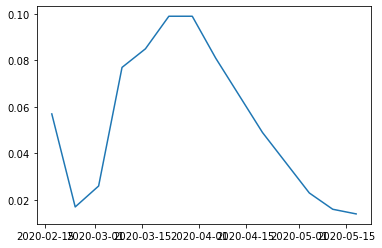

In [5]:
# week <= 8 1527 samples, 87 positive --> 5.7%
labSurv_weeks = range(8,22)
labSurv_pos = [.057,0.017, 0.026, 0.077, 0.085, 0.099, 0.099, 0.081, 0.065, 0.049, 0.036, 0.023, 0.016, 0.014]
labSurv_dates = pd.date_range(datetime.date(2020,2,17),periods=len(labSurv_weeks)*7,freq='D')[::7]
print(labSurv_dates[0])

plt.plot(labSurv_dates,labSurv_pos)

KW10 (up inc.) 2020-02-10 2020-03-09
KW11 2020-03-09 2020-03-16
KW12 2020-03-16 2020-03-23
KW13 2020-03-23 2020-03-30
KW14 2020-03-30 2020-04-06
KW15 2020-04-06 2020-04-13
KW16 2020-04-13 2020-04-20
KW17 2020-04-20 2020-04-27


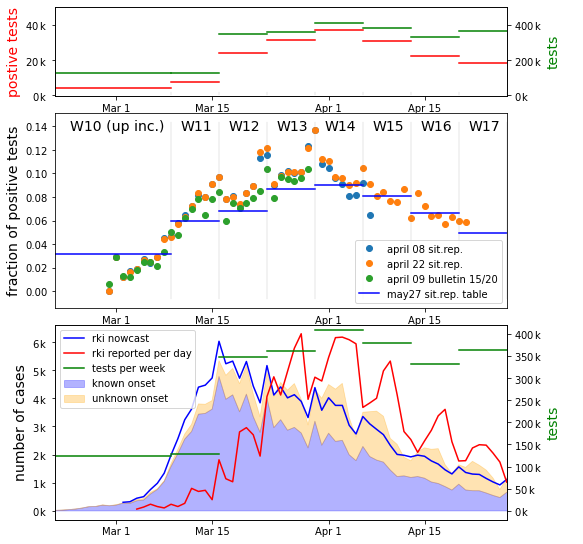

In [6]:
# Testing Data grabbed from situation reports graph with fraction of positive tests by date of sampling not testing
ts_ts = pd.date_range(datetime.date(2020,2,29),periods=(60),freq='D')
ts_pos = {}
# bulletin by sampling, adding 0 to match testing-date
ts_pos["april 08 sit.rep."] = [0,0.029, 0.012, 0.017, 0.019, 0.027, 0.024, 0.029, 0.045, 0.047, 0.058, 0.065, 0.072, 0.082, 0.08, 0.091, 0.097, 0.078, 0.081, 0.073, 0.083, 0.089, 0.113, 0.116, 0.09, 0.099, 0.102, 0.1, 0.101, 0.123, 0.137, 0.108, 0.105, 0.096, 0.091, 0.081, 0.082, 0.092, 0.065]
ts_pos["april 22 sit.rep."] = [0,0.029, 0.012, 0.016, 0.019, 0.026, 0.025, 0.029, 0.044, 0.046, 0.057, 0.063, 0.072, 0.083, 0.08, 0.091, 0.097, 0.078, 0.08, 0.074, 0.083, 0.089, 0.118, 0.122, 0.091, 0.098, 0.101, 0.101, 0.101, 0.122, 0.137, 0.112, 0.111, 0.097, 0.096, 0.09, 0.092, 0.105, 0.091, 0.081, 0.084, 0.077, 0.076, 0.087, 0.062, 0.083, 0.072, 0.064, 0.065, 0.057, 0.063, 0.06, 0.059]
# bulletin by testing
ts_pos["april 09 bulletin 15/20"] = [0.006, 0.029, 0.013, 0.012, 0.018, 0.025, 0.025, 0.021, 0.033, 0.05, 0.048, 0.062, 0.07, 0.078, 0.065, 0.078, 0.084, 0.06, 0.075, 0.071, 0.075, 0.079, 0.085, 0.104, 0.079, 0.097, 0.095, 0.094, 0.096, 0.104]

for k in ts_pos.keys():
    ts_pos[k] = ma.masked_where(ts_pos[k] == 0,ts_pos[k])

epi_curve = np.sum(np.array(d["known"]),axis=0)
epi_unknown = np.sum(np.array(d["unknown"]),axis=0)
    
# Testing Data grabbed from sitation reports graph with test/positive numbers by date of testing
# only labs with participated in ARS survaillance, 18.6% of all tests.
ts_perday = pd.date_range(datetime.date(2020,3,1),periods=(60),freq='D')
pos_perday = np.array([43, 0, 29, 43, 58, 72, 29, 29, 58, 159, 275, 347, 462, 332, 246, 520, 636, 997, 1040, 1069, 1040, 477, 1098, 968, 1373, 1301, 1344, 751],dtype=np.float64)
total_perday = np.array([549, 968, 2052, 2471, 2688, 2486, 2023, 838, 1445, 3555, 4422, 5116, 6301, 5578, 3165, 6431, 10795, 13728, 15231, 15014, 13627, 5780, 10679, 12659, 14595, 13945, 14552, 8107],dtype=np.float64)

# Generate 

ticks = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15)]
ticks_labels = ["Mar 1","Mar 15","Apr 1","Apr 15"]

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.105,right=0.89,top=0.94,bottom=0.05)
lt = len(testing.keys())

gs = fig.add_gridspec(5, 1)
bx = fig.add_subplot(gs[0:1,0])
ax = fig.add_subplot(gs[1:3,0])
dx = fig.add_subplot(gs[3:5,0])
ex = dx.twinx()

cx = bx.twinx()
#bx.semilogy(ts_perday[:len(pos_perday)],pos_perday,"o",color="red",label="positive test")
#cx.semilogy(ts_perday[:len(total_perday)],total_perday,"o",color="blue",label="total test")

for k,pos in ts_pos.items():
    ax.plot(ts_ts[:len(pos)],pos,"o",label=k)
    
ylim,bylim = ax.get_ylim(),[0,2000]
kwk = sorted(testing.keys())
for i,k in enumerate(kwk[:8]):
    start,end = tpd["startdate"][i:i+2]
    print(k,start,end)
    endi = (end-gstart).days
    
    l = None if i != 0 else "may27 sit.rep. table"
    ax.plot([start,end],[tpd["fraction"][i]]*2,label=l,color="blue")
    ax.plot([end]*2,ylim,color="grey",linewidth=.2)
    bx.plot([end]*2,bylim,color="grey",linewidth=.2)
    
    bx.plot([start,end],[tpd["positive"][i]]*2,color="red")
    cx.plot([start,end],[tpd["tests"][i]]*2,color="green")
    l = None if i != 0 else "tests per day"
    ex.plot([start,end],[tpd["tests"][i]]*2,color="green",label=l)
    

    
    ax.text(end-datetime.timedelta(days=1),ylim[1]*.95,k[1:],fontsize=14,horizontalalignment="right")

#    print(tpd["positive"])
    
ax.legend(loc=4)
ax.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
ax.set_ylabel("fraction of positive tests",fontsize=14)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_labels)


#bx.text(.55,.45,"from Epi. bulletin april 9th",transform=bx.transAxes,fontsize=12)
bx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
bx.set_ylim(-500,50000)
bx.set_ylabel("postive tests",color="red",fontsize=14)
bx.set_xticks(ticks)
bx.set_xticklabels(ticks_labels)

cx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
cx.set_ylim(-5000,500000)
cx.set_ylabel("tests\n",color="green",fontsize=14)

#ax.plot(ts_perday[:len(pos_perday)],pos_perday/total_perday,"+")

reported_start = datetime.date(2020,3,4)
reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
tsr = pd.date_range(reported_start,periods=len(reported),freq="D")

gstart,gend = tpd["startdate"][0],tpd["startdate"][-1]+datetime.timedelta(days=7)
ts = pd.date_range(gstart,periods=(gend-gstart).days,freq='D')


dx.fill_between(ts,np.zeros(len(ts)),epi_curve,color="blue",linewidth=.8,label="known onset",alpha=.3)
dx.fill_between(ts,epi_curve,epi_curve+epi_unknown,color="orange",linewidth=.8,label="unknown onset",alpha=.3)

dx.plot(nowcast_df["date"],nowcast_df["new_infected"],label="rki nowcast",color="blue")
dx.plot(tsr,reported,"-",color="red",label="rki reported per day")

dx.set_xticks(ticks)
dx.set_xticklabels(ticks_labels)
dx.plot([0],[0],color="green",label="tests per week")

dx.legend()
dx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
dx.set_ylabel("number of cases",fontsize=14)

ex.set_ylim(-20000,420000)
ex.set_ylabel("tests",fontsize=14,color="green")


for tx in [bx,cx,dx,ex]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )


fig.savefig("Testing_01.pdf")
fig.savefig("Testing_01.svg")

KW10 (up inc.) 2020-02-10 2020-03-09
KW11 2020-03-09 2020-03-16
KW12 2020-03-16 2020-03-23
KW13 2020-03-23 2020-03-30
KW14 2020-03-30 2020-04-06
KW15 2020-04-06 2020-04-13
KW16 2020-04-13 2020-04-20
KW17 2020-04-20 2020-04-27


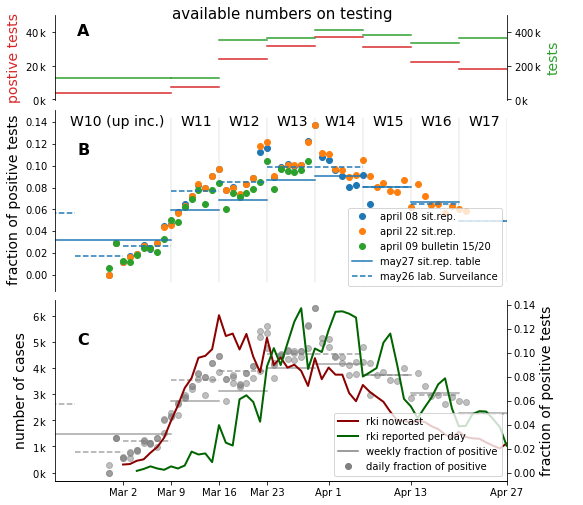

In [14]:
# Testing Data grabbed from situation reports graph with fraction of positive tests by date of sampling not testing
ts_ts = pd.date_range(datetime.date(2020,2,29),periods=(60),freq='D')
ts_pos = {}
# bulletin by sampling, adding 0 to match testing-date
ts_pos["april 08 sit.rep."] = [0,0.029, 0.012, 0.017, 0.019, 0.027, 0.024, 0.029, 0.045, 0.047, 0.058, 0.065, 0.072, 0.082, 0.08, 0.091, 0.097, 0.078, 0.081, 0.073, 0.083, 0.089, 0.113, 0.116, 0.09, 0.099, 0.102, 0.1, 0.101, 0.123, 0.137, 0.108, 0.105, 0.096, 0.091, 0.081, 0.082, 0.092, 0.065]
ts_pos["april 22 sit.rep."] = [0,0.029, 0.012, 0.016, 0.019, 0.026, 0.025, 0.029, 0.044, 0.046, 0.057, 0.063, 0.072, 0.083, 0.08, 0.091, 0.097, 0.078, 0.08, 0.074, 0.083, 0.089, 0.118, 0.122, 0.091, 0.098, 0.101, 0.101, 0.101, 0.122, 0.137, 0.112, 0.111, 0.097, 0.096, 0.09, 0.092, 0.105, 0.091, 0.081, 0.084, 0.077, 0.076, 0.087, 0.062, 0.083, 0.072, 0.064, 0.065, 0.057, 0.063, 0.06, 0.059]
# bulletin by testing
ts_pos["april 09 bulletin 15/20"] = [0.006, 0.029, 0.013, 0.012, 0.018, 0.025, 0.025, 0.021, 0.033, 0.05, 0.048, 0.062, 0.07, 0.078, 0.065, 0.078, 0.084, 0.06, 0.075, 0.071, 0.075, 0.079, 0.085, 0.104, 0.079, 0.097, 0.095, 0.094, 0.096, 0.104]

for k in ts_pos.keys():
    ts_pos[k] = ma.masked_where(ts_pos[k] == 0,ts_pos[k])

epi_curve = np.sum(np.array(d["known"]),axis=0)
epi_unknown = np.sum(np.array(d["unknown"]),axis=0)
    
# Testing Data grabbed from sitation reports graph with test/positive numbers by date of testing
# only labs with participated in ARS survaillance, 18.6% of all tests.
ts_perday = pd.date_range(datetime.date(2020,3,1),periods=(60),freq='D')
pos_perday = np.array([43, 0, 29, 43, 58, 72, 29, 29, 58, 159, 275, 347, 462, 332, 246, 520, 636, 997, 1040, 1069, 1040, 477, 1098, 968, 1373, 1301, 1344, 751],dtype=np.float64)
total_perday = np.array([549, 968, 2052, 2471, 2688, 2486, 2023, 838, 1445, 3555, 4422, 5116, 6301, 5578, 3165, 6431, 10795, 13728, 15231, 15014, 13627, 5780, 10679, 12659, 14595, 13945, 14552, 8107],dtype=np.float64)

# Generate 

#ticks = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15)]
#ticks_labels = ["Mar 1","Mar 15","Apr 1","Apr 15"]

ticks = [datetime.date(2020,3,2),datetime.date(2020,3,9),datetime.date(2020,3,16),datetime.date(2020,3,23),datetime.date(2020,4,1),datetime.date(2020,4,13),datetime.date(2020,4,27)]
ticks_labels = ["Mar 2","Mar 9","Mar 16","Mar 23","Apr 1","Apr 13","Apr 27"]

fig = plt.figure(figsize=(8,7))
fig.subplots_adjust(wspace=0.33,hspace=0.11,left=0.105,right=0.89,top=0.965,bottom=0.04)
fig.suptitle("available numbers on testing",fontsize=15)
lt = len(testing.keys())

gs = fig.add_gridspec(5, 1)
bx = fig.add_subplot(gs[0:1,0])
ax = fig.add_subplot(gs[1:3,0])
dx = fig.add_subplot(gs[3:5,0])
ex = dx.twinx()

cx = bx.twinx()
#bx.semilogy(ts_perday[:len(pos_perday)],pos_perday,"o",color="red",label="positive test")
#cx.semilogy(ts_perday[:len(total_perday)],total_perday,"o",color="blue",label="total test")

for k,pos in ts_pos.items():
    ax.plot(ts_ts[:len(pos)],pos,"o",label=k)
    ex.plot(ts_ts[:len(pos)],pos,"o",label=k,color="grey",alpha=.5)
    
ylim,bylim = ax.get_ylim(),[0,2000]
kwk = sorted(testing.keys())
for i,k in enumerate(kwk[:8]):
    start,end = tpd["startdate"][i:i+2]
    print(k,start,end)
    endi = (end-gstart).days
    
    l = None if i != 0 else "may27 sit.rep. table"
    ax.plot([start,end],[tpd["fraction"][i]]*2,label=l,color="tab:blue")
    ax.plot([end]*2,ylim,color="grey",linewidth=.2)
  #  bx.plot([end]*2,bylim,color="grey",linewidth=.2)
    
    bx.plot([start,end],[tpd["positive"][i]]*2,color="tab:red")
    cx.plot([start,end],[tpd["tests"][i]]*2,color="tab:green")
    l = None if i != 0 else "tests per day"
    ex.plot([start,end],[tpd["fraction"][i]]*2,color="grey",label=l,alpha=.7)

    
    ax.text(end-datetime.timedelta(days=1),ylim[1]*.95,k[1:],fontsize=14,horizontalalignment="right")

#    print(tpd["positive"])
for i,v in enumerate(labSurv_pos[:-1]):
    start,end = labSurv_dates[i],labSurv_dates[i+1]
    l = None if i != 0 else "may26 lab. Surveilance"
    ax.plot([start,end],[v]*2,"--",label=l,color="tab:blue")
    ex.plot([start,end],[v]*2,"--",color="grey",alpha=.7)

    
ax.legend(loc=4)
ax.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
ax.set_ylabel("fraction of positive tests",fontsize=14)
ex.set_ylabel("fraction of positive tests",fontsize=14)
ax.set_xticks([])#[ticks)
cx.set_xticks([])
#ax.set_xticklabels(ticks_labels)


#bx.text(.55,.45,"from Epi. bulletin april 9th",transform=bx.transAxes,fontsize=12)
bx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
bx.set_ylim(-500,50000)
bx.set_ylabel("postive tests",color="tab:red",fontsize=14)
bx.set_xticks([])#ticks)
#bx.set_xticklabels(ticks_labels)

cx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
cx.set_ylim(-5000,500000)
cx.set_ylabel("tests\n",color="tab:green",fontsize=14)

#ax.plot(ts_perday[:len(pos_perday)],pos_perday/total_perday,"+")

reported_start = datetime.date(2020,3,4)
reported = [66,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,1251,667,357,933,798,933,913,620]
tsr = pd.date_range(reported_start,periods=len(reported),freq="D")

gstart,gend = tpd["startdate"][0],tpd["startdate"][-1]+datetime.timedelta(days=7)
ts = pd.date_range(gstart,periods=(gend-gstart).days,freq='D')


#dx.fill_between(ts,np.zeros(len(ts)),epi_curve,color="blue",linewidth=.8,label="known onset",alpha=.3)
#dx.fill_between(ts,epi_curve,epi_curve+epi_unknown,color="orange",linewidth=.8,label="unknown onset",alpha=.3)

dx.plot(nowcast_df["date"],nowcast_df["new_infected"],label="rki nowcast",color="darkred",linewidth=2.0)
dx.plot(tsr,reported,"-",color="darkgreen",label="rki reported per day",linewidth=2.)

dx.set_xticks(ticks)
dx.set_xticklabels(ticks_labels)
dx.plot([0],[0],color="grey",label="weekly fraction of positive")
dx.plot([0],[0],"o",color="grey",label="daily fraction of positive")

dx.legend(loc=4)
dx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,4,27))
dx.set_ylabel("number of cases",fontsize=14)

#ex.set_ylim(-20000,420000)
#ex.set_ylabel("",fontsize=14,color="grey")


for tx in [bx,cx,dx,ex]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )

dx.set_zorder(cx.get_zorder()+10)
dx.patch.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

cx.spines['right'].set_visible(False)
cx.spines['top'].set_visible(False)

dx.spines['right'].set_visible(False)
dx.spines['top'].set_visible(False)
ex.spines['left'].set_visible(False)
ex.spines['top'].set_visible(False)

bx.spines['bottom'].set_visible(False)
cx.spines['bottom'].set_visible(False)

bx.spines['top'].set_visible(False)
bx.spines['left'].set_visible(False)
#dx.spines['bottom'].set_visible(False)
#ex.spines["bottom"].set_visible(False)

for tx,k in zip([cx,ax,dx],["A","B","C"]):
    tx.text(.05,.75,k,transform=tx.transAxes,fontsize=16,weight = 'bold')


fig.savefig("FigTestingPerWeek.svg")
fig.savefig("FigTestingPerWeek.pdf")

0 KW10 (up inc.) 2020-02-10 2020-03-09
1 KW11 2020-03-09 2020-03-16
2 KW12 2020-03-16 2020-03-23
3 KW13 2020-03-23 2020-03-30
4 KW14 2020-03-30 2020-04-06
5 KW15 2020-04-06 2020-04-13
6 KW16 2020-04-13 2020-04-20
7 KW17 2020-04-20 2020-04-27
8 KW18 2020-04-27 2020-05-04
9 KW19 2020-05-04 2020-05-11
10 KW20 2020-05-11 2020-05-18
0.3	0.5	0.2	0.2	0.2	0.2	0.3	0.3	0.3
0.5	0.4	0.7	0.6	0.5	0.5	0.5	0.5	0.6
0.1	0.1	0.1	0.2	0.2	0.2	0.1	0.1	0.1
0.0	0.0	0.0	0.0	0.1	0.1	0.0	0.0	0.0


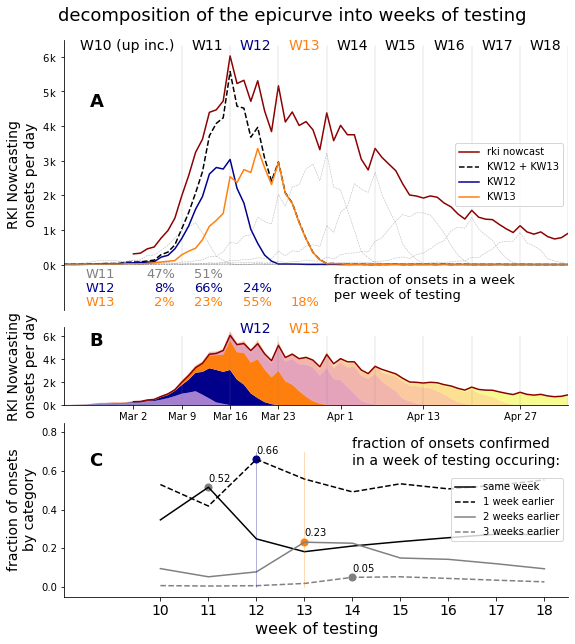

In [18]:
ticks = [datetime.date(2020,3,2),datetime.date(2020,3,9),datetime.date(2020,3,16),datetime.date(2020,3,23),datetime.date(2020,4,1),datetime.date(2020,4,13),datetime.date(2020,4,27)]
tick_labels = ["Mar 2","Mar 9","Mar 16","Mar 23","Apr 1","Apr 13","Apr 27"]

fig = plt.figure(figsize=(8,9))
fig.subplots_adjust(wspace=0.33,hspace=0.22,left=0.105,right=0.98,top=0.93,bottom=0.07)
fig.suptitle("decomposition of the epicurve into weeks of testing",fontsize=18)
lt = len(testing.keys())

plasma = plt.cm.plasma
clrs = []
alphas = [.5]*imputated.shape[0]
for i in range(imputated.shape[0]):
    clrs.append( plasma(i/8.))
    
clrs[2] = "darkblue"
clrs[3] = "tab:orange"

cs_imp = np.cumsum(imputated,axis=1)
cs_imp = (cs_imp.T/cs_imp[...,-1]).T

gs = fig.add_gridspec(6, 1)
ax = fig.add_subplot(gs[0:3,0])
bx = fig.add_subplot(gs[3:4,0])

ax.plot(nowcast_df["date"],nowcast_df["new_infected"],label="rki nowcast",color="darkred")
bx.plot(nowcast_df["date"],nowcast_df["new_infected"],label="rki nowcast",color="darkred",linewidth=1.5)

ylim,bylim = ax.get_ylim(),[0,6000]
kwk = sorted(testing.keys())

cf = [0,0,0,0]
for i,k in enumerate(kwk[:9]):
    start,end = tpd["startdate"][i:i+2]
 #   print(i,k,start,end)
    endi = (end-gstart).days
    ax.plot([end]*2,ylim,color="grey",linewidth=.2)
    bx.plot([end]*2,bylim,color="grey",linewidth=.2)
    
    imp_starti = max(0,(start-gstart).days)
    for j,f,c,o,lcf in zip([0,1,2],cs_imp[1:5,imp_starti],["grey","darkblue","tab:orange","grey"],[0,400,800,900],cf):
        if f > 0.005 and f < 1:
            f *= 100
        #    print(lcf)
            if lcf < 99:
                ax.text(start-datetime.timedelta(days=1),-400-o,"%d%%"%(f-lcf),fontsize=13,color=c,horizontalalignment="right")
            cf[j] = f
    if i in [2,3]:
        bx.text(end-datetime.timedelta(days=1),bx.get_ylim()[1]*.99,k[1:],fontsize=14,horizontalalignment="right",color=clrs[i])
        ax.plot(ts,imputated[i],color=clrs[i],label=k)
        ax.text(end-datetime.timedelta(days=1),ylim[1]*.98,k[1:],fontsize=14,horizontalalignment="right",color=clrs[i])
    else:
        ax.text(end-datetime.timedelta(days=1),ylim[1]*.98,k[1:],fontsize=14,horizontalalignment="right")
        ax.plot(ts,imputated[i],"--",color="grey",linewidth=.5,alpha=.6)

    if i == 0:
        ax.plot(ts,imputated[2]+imputated[3],"--",color="black",label="KW12 + KW13")

for k,o,c in zip(["KW11","KW12","KW13"],[0,400,800],["grey","darkblue","tab:orange"]):
    ax.text(datetime.date(2020,2,24),-400-o,k[1:],color=c,fontsize=13)
        
ax.text(datetime.date(2020,3,31),-1000,"fraction of onsets in a week\nper week of testing",fontsize=13)

stack = bx.stackplot(ts,imputated,alpha=.5,colors=clrs)
stack[2].set_alpha(1)
stack[3].set_alpha(1)

ax.set_xlim(datetime.date(2020,2,21),datetime.date(2020,5,4))
bx.set_xlim(datetime.date(2020,2,21),datetime.date(2020,5,4))

ax.set_ylabel("RKI Nowcasting\nonsets per day",fontsize=14)
bx.set_ylabel("RKI Nowcasting\nonsets per day",fontsize=14)
ax.set_ylim(-1300,6500)
ax.set_xticks([])#ticks)
#ax.set_xticklabels(tick_labels)
ax.set_yticks([0,1000,2000,3000,4000,5000,6000])

bx.set_xticks(ticks)
bx.set_xticklabels(tick_labels)
bx.set_yticks([0,2000,4000,6000])
ax.legend(loc=5)

for tx in [ax,bx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

bx.spines['top'].set_visible(False)
bx.spines['right'].set_visible(False)

# 3rd graph
cx = fig.add_subplot(gs[4:,0])
x = np.zeros((14,cs_imp.shape[0]))

for i,k in enumerate(kwk[:-1]):
    start,end = tpd["startdate"][i:i+2]
    print(i,k,start,end)
    endi = (end-gstart).days
    
    imp_starti = max(0,(start-gstart).days)
    
    wv = np.diff(cs_imp[i][::7])
    x[:i+5,i] = wv[i+4::-1]
#    print(" ".join(["%.1f"%x for x in wv]))

for i,y,k,c,c2,m in zip(range(4),x[1:5,:-2],["same week","1 week earlier","2 weeks earlier","3 weeks earlier"],["black","black","grey","grey"],["grey","darkblue","tab:orange","grey"],["-","--","-","--"]):
    print("\t".join(["%.1f"%z for z in y]))
    
    cx.plot(range(10,19),y,m,label=k,color=c)

    cx.scatter(i+11,y[i+1],color=c2,s=50)
    cx.text(i+11,y[i+1]+.03,"%.2f"%y[i+1])
    
#cx.plot([11,11],[0,.7],"-",color="grey",linewidth=.7,alpha=.5)
cx.plot([12,12],[0,.7],"-",color="darkblue",linewidth=.6,alpha=.5)
cx.plot([13,13],[0,.7],"-",color="tab:orange",linewidth=.6,alpha=.5)
#cx.plot([14,14],[0,.7],"-",color="grey",linewidth=.7,alpha=.5)


cx.text(14.,.55,"fraction of onsets confirmed\nin a week of testing occuring:\n",fontsize=14)
cx.set_ylabel("fraction of onsets\nby category",fontsize=14)
cx.set_xticks(range(10,19))
cx.set_xticklabels(["%d"%d for d in range(10,20)],fontsize=14)
cx.set_xlabel("week of testing",fontsize=16)
cx.set_xlim(8.,18.5)
cx.set_ylim(-.05,.85)
cx.legend(loc=5)


cx.spines['top'].set_visible(False)
cx.spines['right'].set_visible(False)

for tx,k in zip([ax,bx,cx],["A","B","C"]):
    tx.text(.05,.75,k,transform=tx.transAxes,fontsize=18,weight = 'bold')


fig.savefig("FigOnsetsPerTesting.svg")
fig.savefig("FigOnsetsPerTesting.pdf")

0 KW10 (up inc.) 2020-02-10 2020-03-09
0.0 0.1 0.5 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
1 KW11 2020-03-09 2020-03-16
0.0 0.0 0.1 0.4 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
2 KW12 2020-03-16 2020-03-23
0.0 0.0 0.0 0.1 0.7 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
3 KW13 2020-03-23 2020-03-30
0.0 0.0 0.0 0.0 0.2 0.6 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0
4 KW14 2020-03-30 2020-04-06
0.0 0.0 0.0 0.0 0.1 0.2 0.5 0.2 0.0 0.0 0.0 0.0 0.0 0.0
5 KW15 2020-04-06 2020-04-13
0.0 0.0 0.0 0.0 0.0 0.1 0.2 0.5 0.2 0.0 0.0 0.0 0.0 0.0
6 KW16 2020-04-13 2020-04-20
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.5 0.3 0.0 0.0 0.0 0.0
7 KW17 2020-04-20 2020-04-27
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.5 0.3 0.0 0.0 0.0
8 KW18 2020-04-27 2020-05-04
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.6 0.3 0.0 0.0
9 KW19 2020-05-04 2020-05-11
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.5 0.3 0.0
10 KW20 2020-05-11 2020-05-18
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.5 0.3
0.3	0.5	0.2	0.2	0.2	0.2	0.3	0.3	0.3
0.5	0.4	0.7	0.6	0.

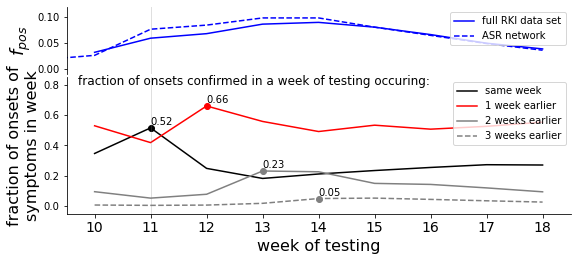

In [15]:
fig = plt.figure(figsize=(8,3.5))
fig.subplots_adjust(wspace=0.33,hspace=0.05,left=0.105,right=0.98,top=0.94,bottom=0.12)
gs = fig.add_gridspec(3, 1)
ax = fig.add_subplot(gs[0:1,0])
bx = fig.add_subplot(gs[1:3,0])


x = np.zeros((14,cs_imp.shape[0]))
for i,k in enumerate(kwk[:-1]):
    start,end = tpd["startdate"][i:i+2]
    print(i,k,start,end)
    endi = (end-gstart).days
    
    imp_starti = max(0,(start-gstart).days)
    
    wv = np.diff(cs_imp[i][::7])
    x[:i+5,i] = wv[i+4::-1]
    print(" ".join(["%.1f"%x for x in wv]))

for i,y,k,c,m in zip(range(4),x[1:5,:-2],["same week","1 week earlier","2 weeks earlier","3 weeks earlier"],["black","red","grey","grey"],["-","-","-","--"]):
    print("\t".join(["%.1f"%z for z in y]))
    
    bx.plot(range(10,19),y,m,label=k,color=c)

    bx.plot(i+11,y[i+1],"o",color=c)
    bx.text(i+11,y[i+1]+.02,"%.2f"%y[i+1])

ax.plot([11,11],[-1,1],"-",color="grey",linewidth=.5,alpha=.5)
bx.plot([11,11],[-1,1],"-",color="grey",linewidth=.5,alpha=.5)

ax.plot(range(10,19),tpd["fraction"][:-3],label="full RKI data set",color="blue")
ax.plot(range(9,19),labSurv_pos[1:-3],"--",label="ASR network",color="blue")
ax.set_xticks([])#range(10,19))
#ax.set_xticklabels(" " for d in range(10,20))
ax.set_xlim(9.5,18.5)
ax.set_ylim(-.01,.12)
ax.legend(loc=1)
ax.set_ylabel(r"$f_{pos}$",fontsize=18)

bx.text(9.7,.7,"fraction of onsets confirmed in a week of testing occuring:\n",fontsize=12)
bx.set_ylabel("fraction of onsets of\nsymptoms in week",fontsize=16)
bx.set_xticks(range(10,19))
bx.set_xticklabels(["%d"%d for d in range(10,20)],fontsize=14)
bx.set_xlabel("week of testing",fontsize=16)
bx.set_xlim(9.5,18.5)
bx.set_ylim(-.05,.85)
bx.legend(loc=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

bx.spines['top'].set_visible(False)
bx.spines['right'].set_visible(False)

fig.savefig("FigTestingFractionPerWeek.pdf")
fig.savefig("FigTestingFractionPerWeek.svg")

706 4554
3293 4554
14415 4554
33937 4554
39167 4554
28765 4554


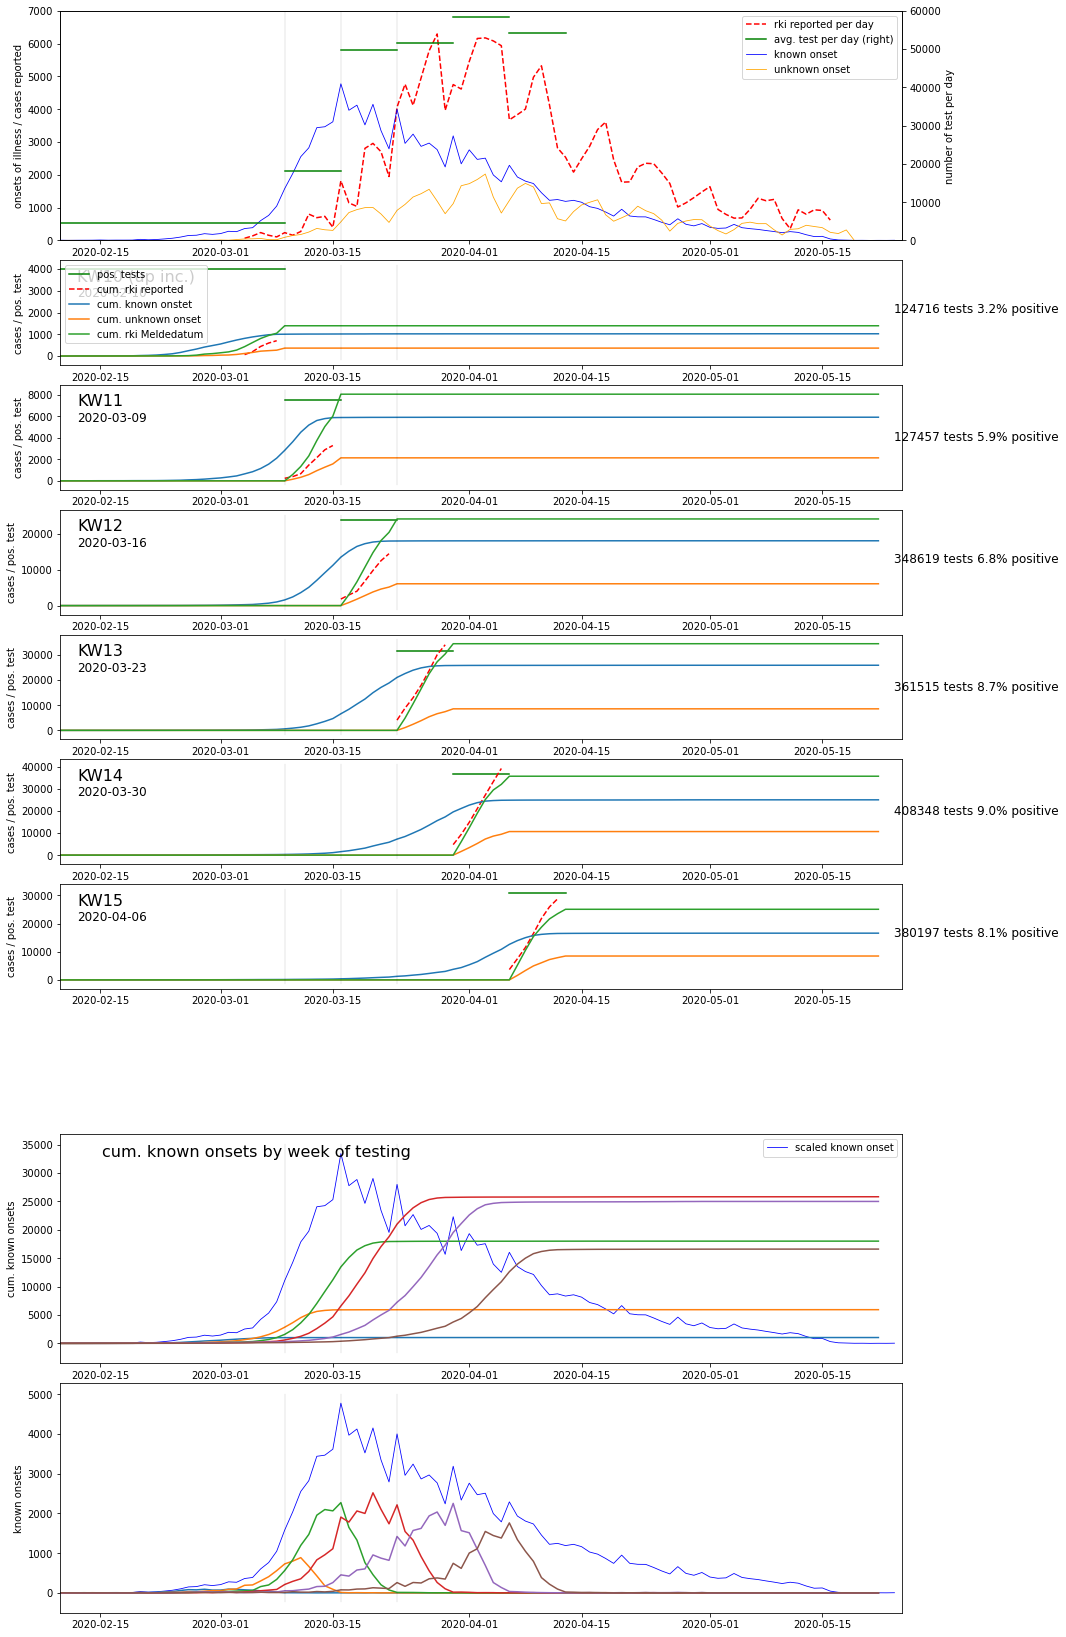

In [10]:
fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.98,top=0.94,bottom=0.05)
lt = len(testing.keys())

gs = fig.add_gridspec(lt+1, 1)

# R_effective
bx = fig.add_subplot(gs[:2,0])
bx.plot(tsr,reported,"--",color="red",label="rki reported per day")
bx.plot([start,start],[0,0],color="green",label="avg. test per day (right)")
bx.set_xlim(gstart,gend)

epi_curve = np.sum(np.array(d["known"]),axis=0)
epi_unknown = np.sum(np.array(d["unknown"]),axis=0)

bx.plot(ts,epi_curve,color="blue",linewidth=.8,label="known onset")
bx.plot(ts,epi_unknown,color="orange",linewidth=.8,label="unknown onset")

bx.legend()
bx.set_ylim(0,7000)
bx.set_ylabel("onsets of illness / cases reported" )

bbx = bx.twinx()
bbx.set_ylim(0,420000/7)
bbx.set_ylabel("number of test per day")

cx = fig.add_subplot(gs[lt-3:lt-1,:])
cx.plot(ts,epi_curve*7,color="blue",linewidth=.8,label="scaled known onset")
cx.text(.05,.9,"cum. known onsets by week of testing",transform=cx.transAxes,fontsize=16)
cx.set_ylabel("cum. known onsets")

dx = fig.add_subplot(gs[lt-1:,:])
dx.plot(ts,epi_curve,color="blue",linewidth=.8,label="scaled known onset")
cx.text(.05,.9,"known onsets by week of testing",transform=dx.transAxes,fontsize=16)
dx.set_ylabel("known onsets")

for i,k in enumerate(sorted(testing.keys())[:-6]):
    start,end = tpd["startdate"][i:i+2]
    endi = (gend-gstart).days-2
    tests = tpd["positive"][i]
    testspd = tpd["tests"][i]/(end-start).days
    
    if i <= 6:
        ax = fig.add_subplot(gs[i+2,0]) 
        ax.plot([start,end],[tests,tests],label="pos. tests",color="green")

      
    i1,i2 = max(0,(start-reported_start).days), (end-reported_start).days
    n_reported = reported[i1:i2]
    if i <= 6:
        ax.plot(ts[i1+(reported_start-gstart).days:i2+(reported_start-gstart).days],np.cumsum(n_reported),"--",color="red",label="cum. rki reported")
    
    
    cs_k = np.cumsum(d["known"][i][:endi])
    cs_uk = np.cumsum(d["unknown"][i][:endi])
    cs_m = np.cumsum(d["meldung"][i][:endi])
    
    if i <= 6:
        ax.plot(ts[:endi],cs_k,label="cum. known onstet")
        ax.plot(ts[:endi],cs_uk,label="cum. unknown onset")
        ax.plot(ts[:endi],cs_m,label="cum. rki Meldedatum") 
    
        ax.set_xlim(gstart,gend)
        ax.text(0.02,.8,k,transform=ax.transAxes,fontsize=16)
        ax.text(0.02,.65,start,transform=ax.transAxes,fontsize=12)
        ax.text(ts[endi+1],tpd["positive"][i]/2.,"%d tests %.1f%% positive"%(tpd["tests"][i],tpd["fraction"][i]*100.),fontsize=12)
        ax.set_ylabel("cases / pos. test")
        axlim = ax.get_ylim()

        if i == 0:
            ax.legend()
        
    for npid in [datetime.date(2020,3,9),datetime.date(2020,3,16),datetime.date(2020,3,23)]:
        ax.plot([npid]*2,axlim,color="black",linewidth=.2,alpha=.5)
        
    #  cx.plot([start,end],[testspd,testspd],label="avg. tests per day",color="green")
    
#    bbx.plot([start,end],np.array([ tpd["tests"][i], tpd["tests"][i] ],dtype=np.float64),color="green")
    bbx.plot([start,end],np.array([ testspd,testspd ],dtype=np.float64),color="green")

    cx.plot(ts[:endi],cs_k)
    dx.plot(ts[:endi],d["known"][i][:endi])
    print(np.sum(n_reported),sum(rki_week["AnzahlFall"]))
   

bxlim,cxlim,dxlim = bx.get_ylim(),cx.get_ylim(),dx.get_ylim()
for npid in [datetime.date(2020,3,9),datetime.date(2020,3,16),datetime.date(2020,3,23)]:
    bx.plot([npid]*2,bxlim,color="black",linewidth=.2,alpha=.5)
    cx.plot([npid]*2,cxlim,color="black",linewidth=.2,alpha=.5)
    dx.plot([npid]*2,dxlim,color="black",linewidth=.2,alpha=.5)
cx.set_xlim(gstart,gend)
dx.set_xlim(gstart,gend)

cx.legend()
fig.savefig("TestingOverview.pdf")

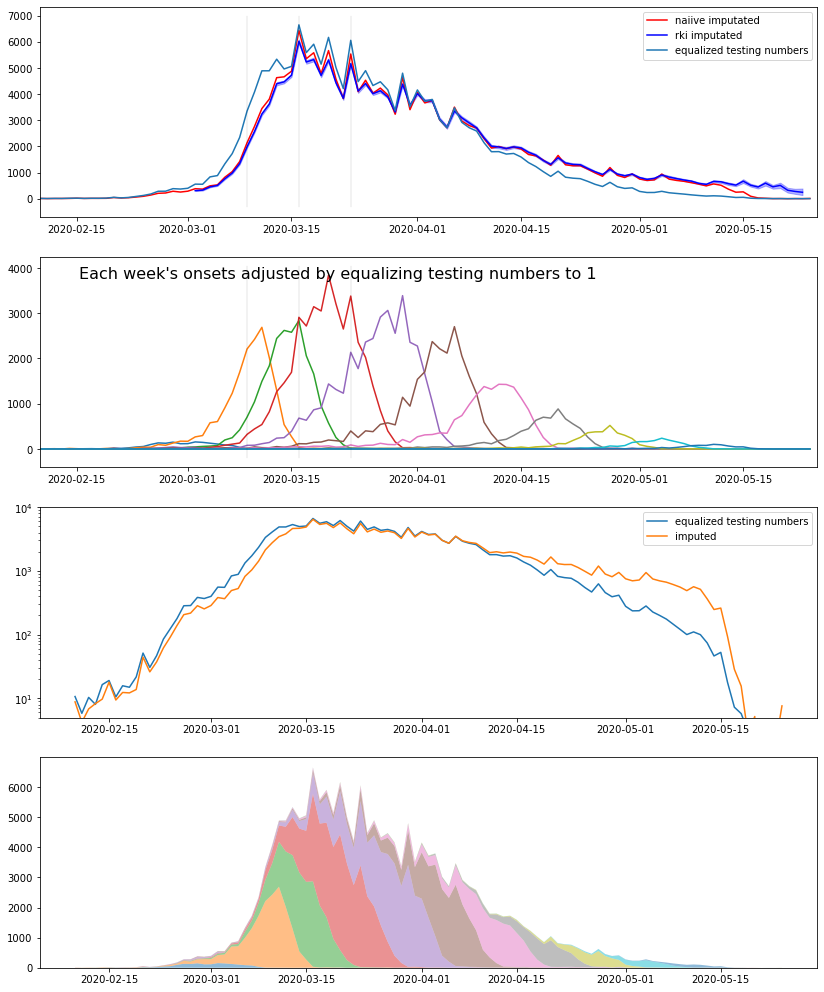

In [11]:


fig = plt.figure(figsize=(12,15))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.98,top=0.94,bottom=0.05)
gs = fig.add_gridspec(4, 1)

ax = fig.add_subplot(gs[0,0])
ax.plot(ts,np.sum(imputated,axis=0),color="red",label="naiive imputated")
ax.plot(nowcast_df["date"],nowcast_df["new_infected"],color="blue",label="rki imputated")
ax.fill_between(nowcast_df["date"],nowcast_df["new_infected_low"],nowcast_df["new_infected_high"],alpha=.3,color="blue")

ax.plot(ts,np.sum(ut_imp,axis=0),label="equalized testing numbers")

ax.legend()
ax.set_xlim(gstart,gend)

# Stacked Plot
plasma = plt.cm.plasma
dx = fig.add_subplot(gs[3,0])
dx.stackplot(ts,ut_imp,alpha=.5)


bx = fig.add_subplot(gs[1,0])
bx.text(.05,.9,"Each week's onsets adjusted by equalizing testing numbers to %d"%(np.max(ut)),transform=bx.transAxes,fontsize=16)
for w_epi in ut_imp:
    bx.plot(ts,w_epi)
bx.set_xlim(gstart,gend)

axlim,bxlim = ax.get_ylim(),bx.get_ylim()
for npid in [datetime.date(2020,3,9),datetime.date(2020,3,16),datetime.date(2020,3,23)]:
    ax.plot([npid]*2,axlim,color="black",linewidth=.2,alpha=.5)
    bx.plot([npid]*2,bxlim,color="black",linewidth=.2,alpha=.5)
    
cx = fig.add_subplot(gs[2,0])
cx.semilogy(ts,np.sum(ut_imp,axis=0),label="equalized testing numbers")
cx.semilogy(ts,np.sum(imputated,axis=0),label="imputed")
cx.set_ylim(5,10000)
cx.legend()


In [12]:
print("equalized_testing = ["+",".join(["%d"%x for x in np.sum(ut_imp,axis=0)])+"]")

equalized_testing = [10,5,10,8,16,19,10,15,14,21,51,30,46,84,123,178,283,285,383,368,398,556,551,833,883,1332,1726,2344,3351,4078,4892,4893,5337,4962,5063,6651,5589,5911,5145,6171,5022,4212,6058,4479,4899,4329,4473,4168,3370,4802,3519,4161,3728,3798,3024,2712,3476,2920,2714,2587,2141,1797,1800,1707,1730,1594,1381,1228,1033,853,1051,821,784,765,663,549,466,626,456,392,415,278,236,237,281,226,200,175,145,121,100,110,99,74,46,52,17,7,5,3,3,0,1,1,3]


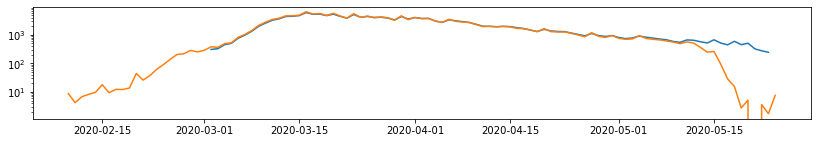

In [13]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.98,top=0.94,bottom=0.05)
gs = fig.add_gridspec(4, 1)

ax = fig.add_subplot(gs[0,0])

ax.semilogy(nowcast_df["date"],nowcast_df["new_infected"])
ax.semilogy(ts,np.sum(imputated,axis=0))

